In [1]:
from matplotlib import *
from __future__ import division
%matplotlib inline
import pandas as pd
import numpy as np
import csv
from matplotlib import pyplot as plt
import pyproj
from sklearn.metrics.pairwise import pairwise_distances



## create fake populations and distances

In [2]:

# Sample Data: Population of locations (Replace with WorldPop data)
locations = ['A', 'B', 'C', 'D', 'E']
population = [10000, 5000, 20000, 15000, 12000]
distances = {
    ('A', 'B'): 10, ('A', 'C'): 30, ('A', 'D'): 50, ('A', 'E'): 70,
    ('B', 'C'): 20, ('B', 'D'): 40, ('B', 'E'): 60,
    ('C', 'D'): 15, ('C', 'E'): 35,
    ('D', 'E'): 25
}

# Convert to DataFrame
pop_df = pd.DataFrame({'Location': locations, 'Population': population})
dist_df = pd.DataFrame([(k[0], k[1], v) for k, v in distances.items()], columns=['From', 'To', 'Distance'])


## Build your Gravity Model 

The number of trips occurring from i to j are inversely proportional to the distance that divides i and j and where masses of origin and destination are the respective populations.


The form with the power law deterrence functions is written as:  
$\Large T_{ij} = K \frac{m_i^\alpha m_j^\beta}{d^\gamma}$

The form with the exponential deterrence functions is written as:  
$\Large T_{ij} = K m_i^\alpha m_j^\beta e^{-d/d_0}$


where $\alpha$ and $\beta$ modulate the attractiveness of masses  
$\gamma$ regulates the decay of the gravity force with distance  
and $d_0$ represents the typical distance travelled by individuals

### create a table containing the two gravity models predicted flows between i and j

In [3]:

def gravity_model(pop_df, dist_df, alpha=1, beta=1):
    flows = []
    for _, row in dist_df.iterrows():
        pop_i = pop_df.loc[pop_df['Location'] == row['From'], 'Population'].values[0]
        pop_j = pop_df.loc[pop_df['Location'] == row['To'], 'Population'].values[0]
        distance = row['Distance']
        flow = (pop_i ** alpha * pop_j ** beta) / (distance ** 2)
        flows.append(flow)
    dist_df['Gravity Flow'] = flows
    return dist_df

def gravity_model_exp(pop_df, dist_df, alpha=1, beta=1):
    flows = []
    for _, row in dist_df.iterrows():
        pop_i = pop_df.loc[pop_df['Location'] == row['From'], 'Population'].values[0]
        pop_j = pop_df.loc[pop_df['Location'] == row['To'], 'Population'].values[0]
        distance = row['Distance']
        flow = (pop_i ** alpha * pop_j ** beta) * np.exp(-distance/d0)
        flows.append(flow)
    dist_df['Gravity Flow Exp'] = flows
    return dist_df

alpha=1
beta=1
d0=5
gravity_results = gravity_model(pop_df, dist_df)
gravity_results = gravity_model_exp(pop_df, dist_df)

print("Gravity Model Results:")
print(gravity_results)


Gravity Model Results:
  From To  Distance  Gravity Flow  Gravity Flow Exp
0    A  B        10  5.000000e+05      6.766764e+06
1    A  C        30  2.222222e+05      4.957504e+05
2    A  D        50  6.000000e+04      6.809989e+03
3    A  E        70  2.448980e+04      9.978345e+01
4    B  C        20  2.500000e+05      1.831564e+06
5    B  D        40  4.687500e+04      2.515970e+04
6    B  E        60  1.666667e+04      3.686527e+02
7    C  D        15  1.333333e+06      1.493612e+07
8    C  E        35  1.959184e+05      2.188517e+05
9    D  E        25  2.880000e+05      1.212830e+06


## Build your Radiation Model

The number of trips occurring from i to j is controlled by the formula


$\Large T_{ij} = T_i \frac{(m_i m_j)}{(m_i + s_{ij})(m_i + m_j + s_{ij})}$




where $m_i$ and $m_j$ are the populations of i and j and $s_{ij}$ is the intervening population


### Add the radiation model predicted flows to the table of results

In [4]:

def radiation_model(pop_df, dist_df):
    flows = []
    for _, row in dist_df.iterrows():
        pop_i = pop_df.loc[pop_df['Location'] == row['From'], 'Population'].values[0]
        pop_j = pop_df.loc[pop_df['Location'] == row['To'], 'Population'].values[0]
        distance = dist_df[(dist_df.From==row['From'])&(dist_df.To==row['To'])].Distance
        loc_s = set(dist_df[dist_df.From==row['From']].groupby(['To']).filter(lambda x:(x['Distance'].max()<distance)&(x['Distance'].max()>0))['To'].values)
        pop_s = pop_df[pop_df.Location.isin(loc_s)]['Population'].sum()
        print(pop_s)
        flow = pop_i * (pop_i * pop_j / ((pop_i + pop_s) * (pop_i + pop_j + pop_s)))
        flows.append(flow)
    dist_df['Radiation Flow'] = flows
    return dist_df

radiation_results = radiation_model(pop_df, dist_df)
print("\nRadiation Model Results:")
print(radiation_results)


0
5000
25000
40000
0
20000
35000
0
15000
0

Radiation Model Results:
  From To  Distance  Gravity Flow  Gravity Flow Exp  Radiation Flow
0    A  B        10  5.000000e+05      6.766764e+06     3333.333333
1    A  C        30  2.222222e+05      4.957504e+05     3809.523810
2    A  D        50  6.000000e+04      6.809989e+03      857.142857
3    A  E        70  2.448980e+04      9.978345e+01      387.096774
4    B  C        20  2.500000e+05      1.831564e+06     4000.000000
5    B  D        40  4.687500e+04      2.515970e+04      375.000000
6    B  E        60  1.666667e+04      3.686527e+02      144.230769
7    C  D        15  1.333333e+06      1.493612e+07     8571.428571
8    C  E        35  1.959184e+05      2.188517e+05     2917.933131
9    D  E        25  2.880000e+05      1.212830e+06     6666.666667


## Now generate flows from population distribution from WorldPop in Turin

### Get data from WorldPop https://hub.worldpop.org/geodata/summary?id=36916

481701


(6.042083309897044, 19.113749924277045, 34.91541671435103, 47.67541666331102)

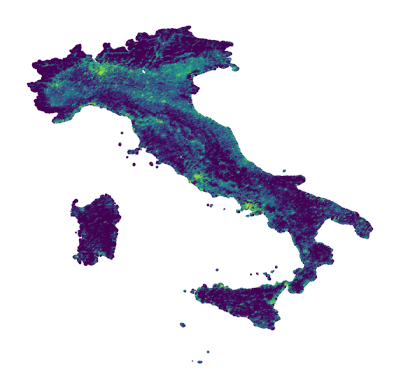

In [99]:
worldpop_df0 = pd.read_csv('ppp_ITA_2020_1km_Aggregated_UNadj.csv')
print(len(worldpop_df0))

plt.scatter(worldpop_df0.X,worldpop_df0.Y,c=np.log(worldpop_df0.Z+1), cmap=cm.viridis, s=.02, marker='s')
plt.gca().set_aspect('equal')

plt.axis('off')

## Let's focus on Turin

156


/var/folders/q5/29y9rnzj2_3f5fwgkltpph4h0000gn/T/ipykernel_19521/661975229.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worldpop_df['x'] = P(worldpop_df.X,worldpop_df.Y)[0]-P(x0,45)[0]
/var/folders/q5/29y9rnzj2_3f5fwgkltpph4h0000gn/T/ipykernel_19521/661975229.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worldpop_df['y'] = P(worldpop_df.X,worldpop_df.Y)[1]-P(6,y0)[1]


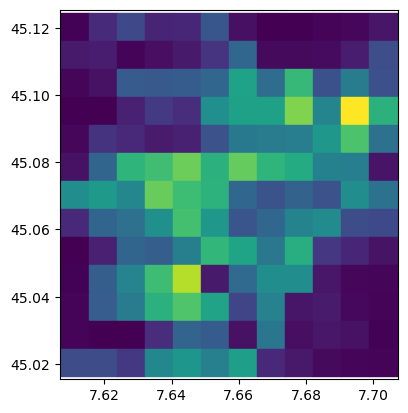

In [73]:
x0 = 7.61000
x1 = 7.7100
y0 = 45.0200
y1 = 45.12322

worldpop_df = worldpop_df0[(worldpop_df0.X<x1)&(worldpop_df0.X>x0)&(worldpop_df0.Y<y1)&(worldpop_df0.Y>y0)]
print(len(worldpop_df))

#project to mercator
P = pyproj.Proj(proj='utm', zone=31, ellps='WGS84', preserve_units=True)
worldpop_df['x'] = P(worldpop_df.X,worldpop_df.Y)[0]-P(x0,45)[0]
worldpop_df['y'] = P(worldpop_df.X,worldpop_df.Y)[1]-P(6,y0)[1]


# Sample Data: Population of locations (Replace with WorldPop data)
locations = worldpop_df.index.tolist()
population = worldpop_df['Z'].tolist()

distances = pairwise_distances(worldpop_df[['x','y']], metric='euclidean')

plt.scatter(worldpop_df.X,worldpop_df.Y,c=worldpop_df.Z, cmap=cm.viridis, s=395, marker='s')
plt.gca().set_aspect('equal')

In [75]:
# Convert to DataFrame
pop_df = pd.DataFrame({'Location': locations, 'Population': population})
pop_dict = pop_df.set_index('Location')['Population'].to_dict()
dist_df = pd.DataFrame(distances, index=locations, columns=locations)

In [76]:
distance_df = dist_df.unstack().reset_index()
distance_df = distance_df.rename(columns={'level_0':'origin','level_1':'destination',0:'distance'})

In [77]:
distance_df['pop orig'] = distance_df['origin'].apply(lambda x: pop_dict[x])
distance_df['pop dest'] = distance_df['destination'].apply(lambda x: pop_dict[x])

distance_df = distance_df[(distance_df['pop orig']>0) & (distance_df['pop dest']>0)]

### Use your gravity model to generate flows with the WorldPop data

In [78]:

# Gravity Model Function
alpha=1
beta=1
gamma=2
d0=200 #meters
def Gravity_pow(x, y, d, alpha, beta, gamma):
    return (x**alpha * y**beta) / (d**gamma)

def Gravity_exp(x, y, d, alpha, beta, d0):
    return x**alpha * y**beta * np.exp(-d/d0)

distance_df['gravity model pow'] = distance_df[['pop orig','pop dest','distance']].apply(lambda x: Gravity_pow(x[0],x[1],x[2],alpha,beta,gamma), axis=1)
distance_df['gravity model exp'] = distance_df[['pop orig','pop dest','distance']].apply(lambda x: Gravity_exp(x[0],x[1],x[2],alpha,beta,d0), axis=1)

distance_df.replace([np.inf, -np.inf], np.nan, inplace=True)

/var/folders/q5/29y9rnzj2_3f5fwgkltpph4h0000gn/T/ipykernel_19521/1956470440.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  return (x**alpha * y**beta) / (d**gamma)


In [79]:
distance_df['p_ij pow'] = distance_df['gravity model pow']/distance_df['pop orig']
distance_df['p_ij exp'] = distance_df['gravity model exp']/distance_df['pop orig']


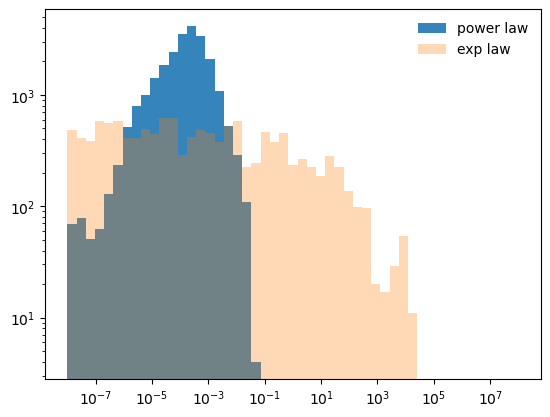

In [80]:
bins=np.logspace(-8,8,50)
plt.hist(distance_df['p_ij pow'],bins=bins,alpha=.9, label='power law');
plt.hist(distance_df['p_ij exp'],bins=bins,alpha=.3, label='exp law');
plt.legend(frameon=False)
plt.yscale('log')
plt.xscale('log')

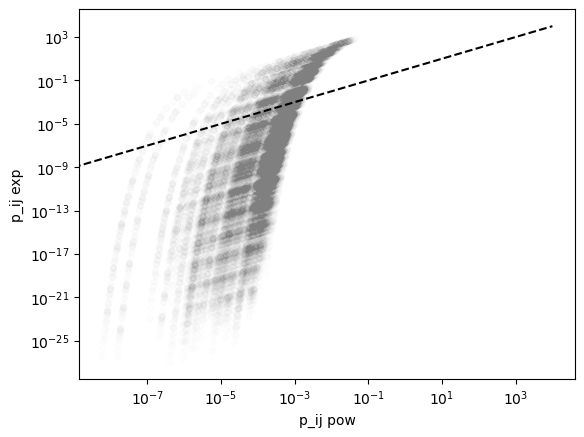

In [81]:
distance_df.plot.scatter(x='p_ij pow',y='p_ij exp', c='grey', alpha=.01)
plt.plot([0,10000], [0,10000], ls='--', c='k')
plt.yscale('log')
plt.xscale('log')

### Use your radiation model to generate flows with the WorldPop data

In [82]:
def get_s(origin,destination):
    df_orig = distance_df[(distance_df.origin==origin)]
    distance = distance_df[(distance_df.origin==origin)&(distance_df.destination==destination)].distance.values[0]
    loc_s = set(df_orig[df_orig['distance']<distance]['destination'].values)
    pop_s = pop_df[pop_df.Location.isin(loc_s)]['Population'].sum()
    return pop_s
        
    
pops_s = []
for i in distance_df.origin.unique():
    print(i)
    for j in distance_df.destination.unique():
        if j>=i:
            pops_s.append([i,j,get_s(i,j)])
            pops_s.append([j,i,get_s(i,j)])

119761
119762
119763
119764
119765
119766
119767
119768
119769
119770
119771
119772
120445
120446
120447
120448
120449
120450
120451
120452
120453
120454
120455
120456
121127
121128
121129
121130
121131
121132
121133
121134
121135
121136
121137
121138
121808
121809
121810
121811
121812
121813
121814
121815
121816
121817
121818
121819
122487
122488
122489
122490
122491
122492
122493
122494
122495
122496
122497
122498
123167
123168
123169
123170
123171
123172
123173
123174
123175
123176
123177
123178
123850
123851
123852
123853
123854
123855
123856
123857
123858
123859
123860
123861
124534
124535
124536
124537
124538
124539
124540
124541
124542
124543
124544
124545
125218
125219
125220
125221
125222
125223
125224
125225
125226
125227
125228
125229
125902
125903
125904
125905
125906
125907
125908
125909
125910
125911
125912
125913
126588
126589
126590
126591
126592
126593
126594
126595
126596
126597
126598
126599
127276
127277
127279
127280
127281
127282
127283
127284
127285
127286
127287

In [84]:
pop_s = pd.DataFrame(pops_s, columns=['origin','destination','s'])

In [85]:
new_df = pd.merge(
    left=distance_df, 
    right=pop_s,
    how='left',
    left_on=['origin', 'destination'],
    right_on=['origin', 'destination']
)

In [86]:

# Radiation Model Function
def radiation_model(pop_i, pop_j, pop_s):
    return pop_i * (pop_i * pop_j / ((pop_i + pop_s) * (pop_i + pop_j + pop_s)))
        

new_df['Radiation model'] = new_df[['pop orig','pop dest','s']].apply(lambda x: radiation_model(x[0],x[1],x[2]),axis=1)


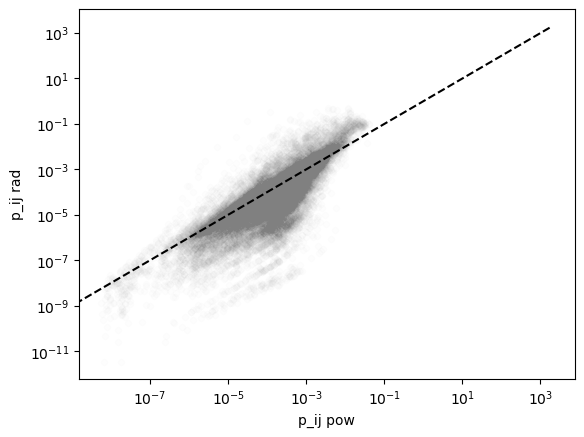

In [87]:
new_df['p_ij rad'] = new_df['Radiation model']/new_df['pop orig']

# Plot Comparison
new_df.plot.scatter(x='p_ij pow',y='p_ij rad', c='grey', alpha=.01)
plt.plot([0,2000], [0,2000], ls='--', c='k')
plt.yscale('log')
plt.xscale('log')


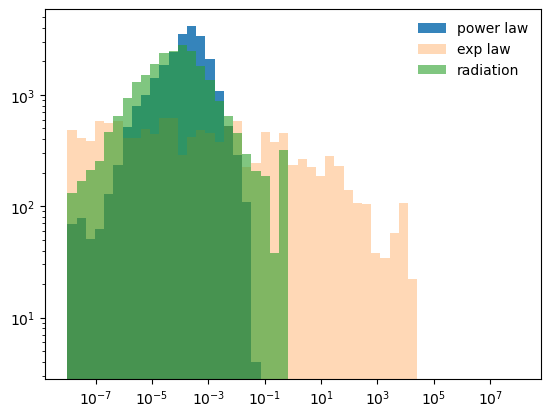

In [89]:
bins=np.logspace(-8,8,50)
plt.hist(new_df['p_ij pow'],bins=bins,alpha=.9, label='power law');
plt.hist(new_df['p_ij exp'],bins=bins,alpha=.3, label='exp law');
plt.hist(new_df['p_ij rad'],bins=bins,alpha=.6, label='radiation');

plt.legend(frameon=False)
plt.yscale('log')
plt.xscale('log')

In [90]:
new_df

,origin,destination,distance,pop orig,pop dest,gravity model pow,gravity model exp,p_ij pow,p_ij exp,s,Radiation model,p_ij rad
0,119761,119761,0.000000,70.382065,70.382065,NaN,4953.635048,NaN,70.382065,0.000000,35.191032,0.500000
1,119761,119761,0.000000,70.382065,70.382065,NaN,4953.635048,NaN,70.382065,0.000000,35.191032,0.500000
2,119761,119762,656.479538,70.382065,2113.258789,0.345122,5583.255264,0.004904,79.327813,70.382065,32.993346,0.468775
3,119761,119763,1312.962915,70.382065,3829.679932,0.156358,379.805927,0.002222,5.396345,4774.808701,0.451349,0.006413
4,119761,119764,1969.450138,70.382065,1756.796509,0.031878,6.539986,0.000453,0.092921,9768.153015,0.076284,0.001084
...,...,...,...,...,...,...,...,...,...,...,...,...
24175,127969,127966,1972.992126,165.213028,1148.424072,0.048741,9.859357,0.000295,0.059677,41340.555420,0.017706,0.000107
24176,127969,127967,1315.332007,165.213028,413.288483,0.039466,95.080276,0.000239,0.575501,6331.880310,0.251258,0.001521
24177,127969,127968,657.667966,165.213028,259.188812,0.099003,1597.911412,0.000599,9.671825,672.477295,7.699501,0.046603
24178,127969,127969,0.000000,165.213028,165.213028,NaN,27295.344606,NaN,165.213028,0.000000,82.606514,0.500000


### Check if scikit-mobility fits the parameters you used in the Gravity models

In [100]:
import skmob
from skmob.utils import utils, constants
import geopandas as gpd
from skmob.models import gravity

In [101]:
gdf = gpd.GeoDataFrame(worldpop_df, geometry=gpd.points_from_xy(worldpop_df['X'], worldpop_df['Y']))
gdf = gdf.reset_index().rename(columns={'Z':'population','index':'tile_ID'})
gdf

,tile_ID,X,Y,population,x,y,geometry
0,119761,7.611250,45.120417,70.382065,-665.202050,17128.632187,POINT (7.61125 45.12042)
1,119762,7.619583,45.120417,2113.258789,-9.793998,17166.124428,POINT (7.61958 45.12042)
2,119763,7.627917,45.120417,3829.679932,645.614010,17203.684657,POINT (7.62792 45.12042)
3,119764,7.636250,45.120417,1756.796509,1301.021972,17241.312875,POINT (7.63625 45.12042)
4,119765,7.644583,45.120417,1854.639160,1956.429890,17279.009083,POINT (7.64458 45.12042)
...,...,...,...,...,...,...,...
151,127965,7.669583,45.020417,1991.971069,4565.056662,6283.726773,POINT (7.66958 45.02042)
152,127966,7.677917,45.020417,1148.424072,5221.615929,6321.695508,POINT (7.67792 45.02042)
153,127967,7.686250,45.020417,413.288483,5878.175177,6359.732244,POINT (7.68625 45.02042)
154,127968,7.694583,45.020417,259.188812,6534.734405,6397.836983,POINT (7.69458 45.02042)


### generate dataframe with columns: origin, destination, flow 

In [93]:
flow_df = new_df[['origin','destination','gravity model exp']].rename(columns={'gravity model exp':'flow'})

# load data about mobility flows into a FlowDataFrame
fdf = skmob.FlowDataFrame(flow_df,tessellation=gdf, tile_id='tile_ID')


/Users/mattiamazzoli/anaconda3/lib/python3.10/site-packages/skmob/core/flowdataframe.py:145: UserWarning: The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).
  warn("The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).")


### Check if scikit-mobility finds the correct parameters you used to generate the flows with the Gravity models

In [94]:
# fit the parameters of the Gravity model from real fluxes
gravity_fit_exp = gravity.Gravity(gravity_type='unconstrained',deterrence_func_type="exponential")
print(gravity_fit_exp)

Gravity(name="Gravity model", deterrence_func_type="exponential", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="unconstrained")


In [96]:
fdf.head()

,origin,destination,flow
0,119761,119761,4953.635048
1,119761,119761,4953.635048
2,119761,119762,5583.255264
3,119761,119763,379.805927
4,119761,119764,6.539986


In [97]:
# fit the parameters of the Gravity model from real fluxes
gravity_fit_exp = gravity.Gravity(gravity_type='unconstrained',deterrence_func_type="exponential")
print(gravity_fit_exp)
gravity_fit_exp.fit(fdf, relevance_column='population')



Gravity(name="Gravity model", deterrence_func_type="exponential", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="unconstrained")


In [98]:
print(gravity_fit_exp)


Gravity(name="Gravity model", deterrence_func_type="exponential", deterrence_func_args=[4.998630957651425], origin_exp=1.0, destination_exp=0.9999893961126654, gravity_type="unconstrained")
